In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_plot,pdp_isolate 
import category_encoders as ce
from sklearn.pipeline import make_pipeline

In [107]:
#Loading the supreme court database
#data = pd.read_csv('data/SCDB_2018_02_caseCentered_Citation.csv',encoding='ISO 8859-1')
data = pd.read_csv('../data/SCDB_2019_01_caseCentered_Citation.csv',encoding='ISO 8859-1')
data.shape

(8966, 53)

In [108]:
#if AdminAction value is 117 in AdminAction if the action has been taken by State Agency
#creating this variables before normalising null values
data['is_adminAction'] = data['adminAction'].notna().astype(int)
data['is_adminActionState']=data['adminActionState'].notna().astype(int)
data['case_argued']=(data['dateArgument'].notna()).astype(int)
data['case_reargued']=(data['dateRearg'].notna()).astype(int)

In [109]:
#Selecting all float columns, they should have been int cols, due to Null values they are designated as Float columns
float_columns = data.select_dtypes('float64').columns
#Replacing all null values with 9999 to convert the float columns to Int
data[float_columns] = data[float_columns].fillna(-1)
for col in float_columns:
    data[col] = data[col].astype('int')


In [110]:
court_dict = {
    
        -1: 'Not Applicable',
        48: 'California Central U.S. District Court',
        50: 'California Northern U.S. District Court',
        51: 'California Southern U.S. District Court',
        55: 'District Of Columbia U.S. District Court',
        58: 'Florida Southern U.S. District Court',
        66: 'Illinois Northern U.S. District Court',
        75: 'Louisiana Eastern U.S. District Court',
        80: 'Massachusetts U.S. District Court',
        81: 'Michigan Eastern U.S. District Court',
        92: 'New Jersey U.S. District Court',
        94: 'New York Eastern U.S. District Court',
        96: 'New York Southern U.S. District Court',
        109: 'Pennsylvania Eastern U.S. District Court',
        301: 'State Appellate Court',
        300: 'State Supreme Court',
        302: 'State Trial Court',
        121: 'Texas Southern U.S. District Court',
        32: 'U.S. Court of Appeals, District of Columbia',
        28: 'U.S. Court of Appeals, Eighth Circuit',
        31: 'U.S. Court of Appeals, Eleventh Circuit',
        8: 'U.S. Court of Appeals, Federal Circuit',
        25: 'U.S. Court of Appeals, Fifth Circuit',
        21: 'U.S. Court of Appeals, First Circuit',
        24: 'U.S. Court of Appeals, Fourth Circuit',
        29: 'U.S. Court of Appeals, Ninth Circuit',
        22: 'U.S. Court of Appeals, Second Circuit',
        27: 'U.S. Court of Appeals, Seventh Circuit',
        26: 'U.S. Court of Appeals, Sixth Circuit',
        30: 'U.S. Court of Appeals, Tenth Circuit',
        23: 'U.S. Court of Appeals, Third Circuit',
        3: 'U.S. Court of Claims, Court of Federal Claims',
        9: 'U.S. Tax Court',
        126: 'Virginia Eastern U.S. District Court',
        9999:'Other Courts'
                                }

In [111]:
#updatining caseOrigin with court dict values, other values will be replaced with 9999
data['caseOrigin']=data['caseOrigin'].apply(lambda x: x if x in court_dict.keys() else 9999)
#updatining caseSource with court dict values, other values will be replaced with 9999
data['caseSource']=data['caseSource'].apply(lambda x: x if x in court_dict.keys() else 9999)

In [112]:
#updatining petitioner with top 15 values, other values will be replaced with 9999
petition_category = data['petitioner'].value_counts(ascending=False)[:15].index.values
data['petitioner']=data['petitioner'].apply(lambda x: x if x in petition_category else 9999)
#updatining respondent with top 15 values, other values will be replaced with 9999
respondent_category = data['respondent'].value_counts(ascending=False)[:15].index.values
data['respondent']=data['respondent'].apply(lambda x: x if x in petition_category else 9999)

In [113]:
#Separating the variables based on data from the codebook
identity_variables = ['caseId', 'docketId', 'caseIssuesId', 'voteId', 'usCite','sctCite', 'ledCite',
                      'lexisCite', 'docket','caseName']

#Removing following variable from background
#adminAction and  adminActionState, being replaced with boolean features 
background_variables=['petitioner', 'petitionerState', 'respondent', 'respondentState','jurisdiction', 
                      'threeJudgeFdc', 'caseOrigin', 'caseOriginState',
                      'caseSource', 'caseSourceState','lcDisagreement', 'certReason', 'lcDisposition','issueArea']

outcome_variables = ['decisionType','declarationUncon','caseDisposition','caseDispositionUnusual',
                     'precedentAlteration','partyWinning']
vote_variables =['voteUnclear','majVotes','minVotes']

In [114]:
#Conveting date columns to date format
date_columns = ['dateArgument','dateRearg','dateDecision']
for col in date_columns:
    data[col]=pd.to_datetime(data[col],errors='coerce')

In [74]:
#Sorting the data based on decisiondate - Useful for generating features
data = data.sort_values('dateDecision').reset_index(drop=True)

In [119]:
#Removing unspecified  and decisions with null valuesfrom the database
data = data[data['partyWinning'].isin([0,1])]
data.shape
#19 rows have been removed

(8947, 57)

In [120]:
#majority class base prediction is
data['partyWinning'].value_counts(normalize=True)
#64% is base line prediction

1    0.639656
0    0.360344
Name: partyWinning, dtype: float64

In [121]:
#Getting the ROC value for baseline prediction
y_pred = np.ones(len(data))
y_true = data['partyWinning'].values
roc_auc_score(y_true,y_pred)

0.5

In [122]:
new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState','argued_since','reargued_since']
#new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState']

In [123]:

prev_vote_variables = ['prev_'+item for item in vote_variables]
prev_outcome_variables = ['prev_'+item for item in outcome_variables]
#From previous same issue what was the decision and voting data 
data[prev_vote_variables] = data.groupby('issueArea')[vote_variables].shift(1)
data[prev_outcome_variables] = data.groupby('issueArea')[outcome_variables].shift(1)
data['prev_votes']=data['prev_majVotes']+data['prev_minVotes']

In [124]:
data['argued_since'] = (data['dateDecision']-data['dateArgument']).dt.days
data['reargued_since'] = (data['dateDecision']-data['dateRearg']).dt.days


In [127]:
data['argued_since']=pd.qcut(data['argued_since'],5,labels=[1,2,3,4,5])

In [139]:
data['argued_since'] = data['argued_since'].cat.add_categories(-1)

In [140]:
data = data.fillna(-1)

In [ ]:
data['argued_since']=pd.qcut(data['argued_since'],5,labels=[1,2,3,4,5],duplicates='drop')
#data['reargued_since']=pd.qcut(data['reargued_since'],5,labels=[1,2,3,4],duplicates='drop')

In [141]:
#Setting a basic model to fit the data
target = 'partyWinning'
features = background_variables+new_features+prev_vote_variables+prev_outcome_variables

In [142]:
testsize = 1000
test = data[-testsize:]
val = data[-testsize*2:-testsize]
train = data[:-testsize*2]
test.shape,val.shape,train.shape

((1000, 69), (1000, 69), (6947, 69))

In [143]:
train[target].value_counts(normalize=True),val[target].value_counts(normalize=True),test[target].value_counts(normalize=True)

(1    0.635094
 0    0.364906
 Name: partyWinning, dtype: float64, 1    0.635
 0    0.365
 Name: partyWinning, dtype: float64, 1    0.676
 0    0.324
 Name: partyWinning, dtype: float64)

In [144]:
train = train.fillna(-1)
test = test.fillna(-1)
val = val.fillna(-1)


In [145]:
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]
X_train = train[features]
y_train = train[target]

In [146]:
len(features)

29

In [147]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=31,min_samples_split=5,max_depth=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=31, verbose=0,
                       warm_start=False)

In [148]:

print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(X_test)))

ROC score for Train is: 0.8861553840073959
ROC score for Val is: 0.6746758709955776
ROC score for Test is: 0.6552546752867265
Accuracy score for Train is: 0.7498200662156327
Accuracy score for Val is: 0.657
Accuracy score for Test is: 0.677


In [89]:
# ROC score for Train is: 0.8763873671857065
# ROC score for Val is: 0.6722295329522165
# ROC score for Test is: 0.6508521934778732
# Accuracy score for Train is: 0.7475169137757305
# Accuracy score for Val is: 0.655
# Accuracy score for Test is: 0.672

# ROC score for Train is: 0.859208892738043
# ROC score for Val is: 0.6656455614281092
# ROC score for Test is: 0.6575563289142137
# Accuracy score for Train is: 0.742046926730963
# Accuracy score for Val is: 0.668
# Accuracy score for Test is: 0.669

In [179]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=1000,learning_rate=0.02,objective='binary:logistic',reg_alpha=1.5,reg_lambda=2,random_state=31,scale_pos_weight=1)
)
pipeline.fit(X_train,y_train)
print("ROC score for Train is:",roc_auc_score(y_train,pipeline.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,pipeline.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,pipeline.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,pipeline.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,pipeline.predict(X_test)))

ROC score for Train is: 0.7522715974543159
ROC score for Val is: 0.656943156078093
ROC score for Test is: 0.6576014500693989
Accuracy score for Train is: 0.7060601698574924
Accuracy score for Val is: 0.657
Accuracy score for Test is: 0.666


In [165]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['argued_since'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'argued_since',
                                          'data_type': CategoricalDtype(categories=[1, 2, 3, 4, 5, -1], ordered=True),
                                          'mapping':  1.0    1
 2.0    2
 3.0    3
 4.0    4
 5.0    5
-1.0    6
 NaN   -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('xgbclassifier',
                 XG...r='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.02,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_job

In [149]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000,learning_rate=0.02,objective='binary:logistic',random_state=31)
xgboost.fit(X_train,y_train,eval_metric='auc',eval_set=[(X_train,y_train),(X_val,y_val)],early_stopping_rounds=250)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields argued_since

In [28]:
import lgbm
from lgbm import LGBMClassifier

ModuleNotFoundError: No module named 'lgbm'

In [166]:
print("ROC score for Train is:",roc_auc_score(y_train,pipeline.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,pipeline.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,pipeline.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,pipeline.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,pipeline.predict(X_test)))

ROC score for Train is: 0.7627803676900546
ROC score for Val is: 0.6552993204616546
ROC score for Test is: 0.654368927606107
Accuracy score for Train is: 0.7118180509572477
Accuracy score for Val is: 0.629
Accuracy score for Test is: 0.635


In [91]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,xgboost.predict(X_test)))

ROC score for Train is: 0.7442371004664994
ROC score for Val is: 0.6735282062344946
ROC score for Test is: 0.6413539060963731
Accuracy score for Train is: 0.6959838779329207
Accuracy score for Val is: 0.662
Accuracy score for Test is: 0.65


In [ ]:
# ROC score for Train is: 0.7758706277752707
# ROC score for Val is: 0.659393808650631
# ROC score for Test is: 0.6535297318803133
# Accuracy score for Train is: 0.707787534187419
# Accuracy score for Val is: 0.659
# Accuracy score for Test is: 0.664

# ROC score for Train is: 0.7714897764192903
# ROC score for Val is: 0.6593743932693344
# ROC score for Test is: 0.6524001810939722
# Accuracy score for Train is: 0.7073556931049374
# Accuracy score for Val is: 0.665
# Accuracy score for Test is: 0.668

In [50]:
features

['petitioner',
 'petitionerState',
 'respondent',
 'respondentState',
 'jurisdiction',
 'threeJudgeFdc',
 'caseOrigin',
 'caseOriginState',
 'caseSource',
 'caseSourceState',
 'lcDisagreement',
 'certReason',
 'lcDisposition',
 'issueArea',
 'case_argued',
 'case_reargued',
 'is_adminAction',
 'is_adminActionState',
 'argued_since',
 'reargued_since',
 'prev_voteUnclear',
 'prev_majVotes',
 'prev_minVotes',
 'prev_decisionType',
 'prev_declarationUncon',
 'prev_caseDisposition',
 'prev_caseDispositionUnusual',
 'prev_precedentAlteration',
 'prev_partyWinning']

In [92]:
#Permutation importance with randomforest
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_xgboost,feature_names=features,top=None)

Weight,Feature
0.0450 ± 0.0203,certReason
0.0373 ± 0.0108,respondent
0.0264 ± 0.0143,petitioner
0.0151 ± 0.0106,issueArea
0.0128 ± 0.0092,lcDisagreement
0.0107 ± 0.0132,case_argued
0.0077 ± 0.0122,lcDisposition
0.0069 ± 0.0031,caseOriginState
0.0047 ± 0.0077,caseSource
0.0034 ± 0.0096,argued_since


In [93]:
#Permutation importance with randomforest
perm_rfc = PermutationImportance(rfc, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_rfc,feature_names=features,top=None)

Weight,Feature
0.0332 ± 0.0129,respondent
0.0203 ± 0.0159,certReason
0.0148 ± 0.0109,petitioner
0.0129 ± 0.0114,argued_since
0.0103 ± 0.0108,lcDisposition
0.0099 ± 0.0062,issueArea
0.0090 ± 0.0092,case_argued
0.0061 ± 0.0100,caseSource
0.0054 ± 0.0021,caseOriginState
0.0046 ± 0.0075,lcDisagreement


In [94]:
#Selecting features from perumation importances
feature_importances_rfc = pd.Series(dict(zip(features,perm_rfc.feature_importances_)))
feature_importances_xgb = pd.Series(dict(zip(features,perm_xgboost.feature_importances_)))
#feature_importances.sort_values().plot(kind='barh',figsize=(10,6))

In [95]:
selected_features_rfc = feature_importances_rfc[feature_importances_rfc >0].sort_values(ascending=False).index.tolist()
selected_features_xgb = feature_importances_xgb[feature_importances_xgb >0].sort_values(ascending=False).index.tolist()


In [96]:
len(selected_features_rfc),len(selected_features_xgb)

(22, 20)

In [97]:
selected_features = list((set(selected_features_rfc)|set(selected_features_xgb)))
selected_features

['caseOriginState',
 'prev_decisionType',
 'petitioner',
 'petitionerState',
 'caseSourceState',
 'prev_minVotes',
 'certReason',
 'case_argued',
 'is_adminActionState',
 'caseOrigin',
 'prev_caseDisposition',
 'threeJudgeFdc',
 'respondentState',
 'prev_voteUnclear',
 'is_adminAction',
 'lcDisposition',
 'argued_since',
 'caseSource',
 'respondent',
 'prev_caseDispositionUnusual',
 'lcDisagreement',
 'prev_majVotes',
 'prev_precedentAlteration',
 'issueArea',
 'prev_partyWinning']

In [98]:
len(selected_features)

25

In [99]:
#Running the model with selected features
rfc.fit(train[selected_features],y_train)
print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(test[selected_features])))

ROC score for Train is: 0.883071125598679
ROC score for Val is: 0.6786193506633589
ROC score for Test is: 0.6343296550525676
Accuracy score for Train is: 0.7516913775730532
Accuracy score for Val is: 0.659
Accuracy score for Test is: 0.662


In [100]:
xgboost.fit(train[selected_features],y_train,eval_metric='auc',eval_set=[(train[selected_features],y_train),(val[selected_features],y_val)],early_stopping_rounds=100)

[0]	validation_0-auc:0.60835	validation_1-auc:0.60595
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.60835	validation_1-auc:0.60595
[2]	validation_0-auc:0.609116	validation_1-auc:0.606649
[3]	validation_0-auc:0.609107	validation_1-auc:0.606649
[4]	validation_0-auc:0.609117	validation_1-auc:0.606649
[5]	validation_0-auc:0.60918	validation_1-auc:0.607233
[6]	validation_0-auc:0.608915	validation_1-auc:0.607251
[7]	validation_0-auc:0.609091	validation_1-auc:0.60845
[8]	validation_0-auc:0.608984	validation_1-auc:0.60867
[9]	validation_0-auc:0.620453	validation_1-auc:0.616212
[10]	validation_0-auc:0.620337	validation_1-auc:0.616535
[11]	validation_0-auc:0.624787	validation_1-auc:0.620966
[12]	validation_0-auc:0.625193	validation_1-auc:0.622908
[13]	validation_0-auc:0.624625	validation_1-auc:0.621178
[14]	validation_0-auc:0.626973	validation_1-auc:0.624047
[15]

[141]	validation_0-auc:0.693338	validation_1-auc:0.675142
[142]	validation_0-auc:0.693397	validation_1-auc:0.675263
[143]	validation_0-auc:0.693681	validation_1-auc:0.674669
[144]	validation_0-auc:0.693688	validation_1-auc:0.674687
[145]	validation_0-auc:0.693728	validation_1-auc:0.674738
[146]	validation_0-auc:0.694107	validation_1-auc:0.675058
[147]	validation_0-auc:0.694254	validation_1-auc:0.675308
[148]	validation_0-auc:0.694306	validation_1-auc:0.675239
[149]	validation_0-auc:0.694386	validation_1-auc:0.675252
[150]	validation_0-auc:0.694408	validation_1-auc:0.675084
[151]	validation_0-auc:0.694528	validation_1-auc:0.675306
[152]	validation_0-auc:0.694982	validation_1-auc:0.675399
[153]	validation_0-auc:0.694999	validation_1-auc:0.675403
[154]	validation_0-auc:0.695294	validation_1-auc:0.675088
[155]	validation_0-auc:0.695257	validation_1-auc:0.675084
[156]	validation_0-auc:0.695586	validation_1-auc:0.67528
[157]	validation_0-auc:0.695565	validation_1-auc:0.67547
[158]	validation

[283]	validation_0-auc:0.714033	validation_1-auc:0.676801
[284]	validation_0-auc:0.714023	validation_1-auc:0.676658
[285]	validation_0-auc:0.714053	validation_1-auc:0.676581
[286]	validation_0-auc:0.714269	validation_1-auc:0.676633
[287]	validation_0-auc:0.714486	validation_1-auc:0.676697
[288]	validation_0-auc:0.714871	validation_1-auc:0.676891
[289]	validation_0-auc:0.715078	validation_1-auc:0.676904
[290]	validation_0-auc:0.715051	validation_1-auc:0.676805
[291]	validation_0-auc:0.715254	validation_1-auc:0.676844
[292]	validation_0-auc:0.715346	validation_1-auc:0.676835
[293]	validation_0-auc:0.715429	validation_1-auc:0.67668
[294]	validation_0-auc:0.715647	validation_1-auc:0.676887
[295]	validation_0-auc:0.71575	validation_1-auc:0.676723
[296]	validation_0-auc:0.715963	validation_1-auc:0.676831
[297]	validation_0-auc:0.716084	validation_1-auc:0.6769
[298]	validation_0-auc:0.716251	validation_1-auc:0.677038
[299]	validation_0-auc:0.716361	validation_1-auc:0.677116
[300]	validation_0

[425]	validation_0-auc:0.729842	validation_1-auc:0.677191
[426]	validation_0-auc:0.729923	validation_1-auc:0.677174
[427]	validation_0-auc:0.730051	validation_1-auc:0.677191
[428]	validation_0-auc:0.730122	validation_1-auc:0.677217
[429]	validation_0-auc:0.73023	validation_1-auc:0.677299
[430]	validation_0-auc:0.730328	validation_1-auc:0.677221
[431]	validation_0-auc:0.730507	validation_1-auc:0.677165
[432]	validation_0-auc:0.730554	validation_1-auc:0.677135
[433]	validation_0-auc:0.730701	validation_1-auc:0.677161
[434]	validation_0-auc:0.730767	validation_1-auc:0.67712
[435]	validation_0-auc:0.730803	validation_1-auc:0.677064
[436]	validation_0-auc:0.730908	validation_1-auc:0.67704
[437]	validation_0-auc:0.730999	validation_1-auc:0.677023
[438]	validation_0-auc:0.731164	validation_1-auc:0.677187
[439]	validation_0-auc:0.731237	validation_1-auc:0.67726
[440]	validation_0-auc:0.731307	validation_1-auc:0.677208
[441]	validation_0-auc:0.731413	validation_1-auc:0.677114
[442]	validation_0

[567]	validation_0-auc:0.744416	validation_1-auc:0.678442
[568]	validation_0-auc:0.744476	validation_1-auc:0.678399
[569]	validation_0-auc:0.744567	validation_1-auc:0.678283
[570]	validation_0-auc:0.744609	validation_1-auc:0.678205
[571]	validation_0-auc:0.744678	validation_1-auc:0.678227
[572]	validation_0-auc:0.744731	validation_1-auc:0.678404
[573]	validation_0-auc:0.74478	validation_1-auc:0.678417
[574]	validation_0-auc:0.744818	validation_1-auc:0.678382
[575]	validation_0-auc:0.744918	validation_1-auc:0.678222
[576]	validation_0-auc:0.744999	validation_1-auc:0.67827
[577]	validation_0-auc:0.745102	validation_1-auc:0.678399
[578]	validation_0-auc:0.745221	validation_1-auc:0.678568
[579]	validation_0-auc:0.745349	validation_1-auc:0.678537
[580]	validation_0-auc:0.745428	validation_1-auc:0.678507
[581]	validation_0-auc:0.745481	validation_1-auc:0.678572
[582]	validation_0-auc:0.745561	validation_1-auc:0.678537
[583]	validation_0-auc:0.745775	validation_1-auc:0.678572
[584]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=31,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [101]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,xgboost.predict(test[selected_features])))

ROC score for Train is: 0.7462197495936098
ROC score for Val is: 0.6788739078848021
ROC score for Test is: 0.643951415596947
Accuracy score for Train is: 0.7021736001151576
Accuracy score for Val is: 0.666
Accuracy score for Test is: 0.657


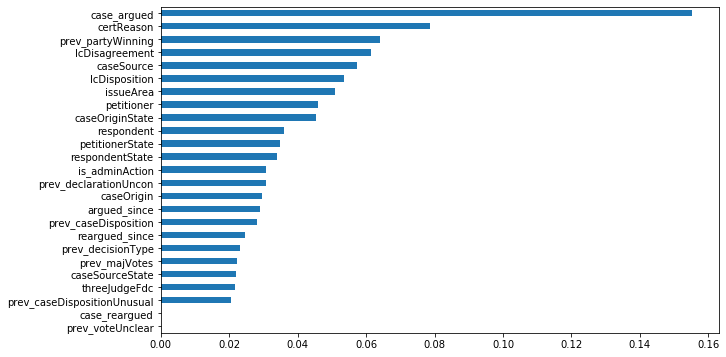

In [61]:
#Selected Feature Importances of the model from Random Forest Classifier
pd.Series(dict(zip(selected_features,xgboost.feature_importances_))).sort_values().plot(kind='barh',figsize=(10,6))

In [102]:
#Classification report for Test based on RandomForestClassifier
print(classification_report(y_test,rfc.predict(test[selected_features])))

              precision    recall  f1-score   support

           0       0.43      0.14      0.21       323
           1       0.69      0.91      0.79       677

    accuracy                           0.66      1000
   macro avg       0.56      0.52      0.50      1000
weighted avg       0.60      0.66      0.60      1000



In [103]:
#Classification report for Test based on Xgboost
print(classification_report(y_test,xgboost.predict(test[selected_features])))

              precision    recall  f1-score   support

           0       0.45      0.25      0.32       323
           1       0.70      0.85      0.77       677

    accuracy                           0.66      1000
   macro avg       0.57      0.55      0.55      1000
weighted avg       0.62      0.66      0.63      1000



In [104]:
#Getting the confsion matrix to plot it using heatmap
con_matrix = pd.DataFrame(confusion_matrix(y_test,xgboost.predict(test[selected_features])))
con_matrix.index = ['Negative','Positive']
con_matrix.columns = ['Predicted Negative','Predicted Positive']
con_matrix

,Predicted Negative,Predicted Positive
Negative,81,242
Positive,101,576


In [ ]:
sns.heatmap??

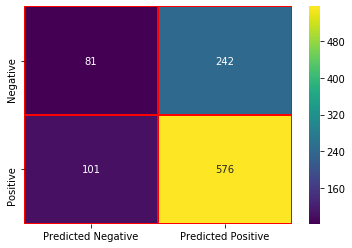

In [105]:
confusion_matrix_fig = sns.heatmap(con_matrix,annot=True,fmt='d',robust=True,cmap='viridis',linewidths=0.5,linecolor='red');
confusion_matrix_fig

In [67]:
from sklearn.model_selection import KMeans

ImportError: cannot import name 'KMeans' from 'sklearn.model_selection' (/home/vishnu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/__init__.py)

In [ ]:
#Plotting pdp plot for each of the features
for f in selected_features:

    isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature=f,
    num_grid_points=100)

    pdp_plot(isolated,feature_name=f,plot_pts_dist=True)

In [ ]:
import shap
explainer = shap.TreeExplainer(xgboost)
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[2]][selected_features]),X_test.iloc[[2]][selected_features])


In [ ]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [ ]:
selected_features

In [ ]:
fig = shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [ ]:
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val[selected_features], y_val)
eli5.show_weights(perm_xgboost,feature_names=selected_features,top=None)

In [ ]:
X_train[selected_features].nunique()

In [ ]:
isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature='argued_since',
    num_grid_points=100)
fig = pdp_plot(isolated,feature_name='argued_since',plot_pts_dist=True)

In [ ]:
len(features),len(selected_features)

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
thresholds,truepositive,falsepositive = roc_curve(y_test,xgboost.predict_proba(X_test[selected_features])[:,1])

In [ ]:
falsepositive,truepositive,thresholds = roc_curve(y_test,xgboost.predict_proba(X_test[selected_features])[:,1])

In [ ]:
plt.scatter(thresholds,truepositive)
plt.scatter(thresholds,falsepositive)

In [ ]:
plt.style.use('fivethirtyeight')
fig = plt.figure(dpi=172)
plt.scatter(falsepositive,truepositive)
plt.title('ROC Curve', fontweight = 'bold', fontsize = 10)
plt.xlabel('False Positive Rate', fontsize = 8)
plt.ylabel('True Positive Rate', fontsize = 8)

In [ ]:
#getting a test value for generating shap value
shaprow = X_test[selected_features].sample(1,random_state=5)
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

In [ ]:
#Generating the shapvalue for the selected test row
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)

In [ ]:
#Now, lets see the predicted probablit when the certReason is changed to 10
shaprow['certReason']=10
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

In [ ]:
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)


In [ ]:
ggpot = shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)

In [ ]:
Html_file= open('shaphtml.html',"w")
Html_file.write(ff)
Html_file.close

In [ ]:
ff

In [ ]:
from joblib import dump
dump(xgboost, '../assets/xgboost.joblib')

In [ ]:
shaprow

In [ ]:
predict_data = pd.DataFrame(
    columns = ['threeJudgeFdc', 'petitioner', 'case_argued', 'lcDisposition', 'respondent', 
        'certReason', 'caseOriginState', 'petitionerState', 'lcDisagreement', 'respondentState',
         'caseSourceState', 'issueArea', 'caseSource'],
    #Hard coding threejudgefdc, need to get the input later
    data = [[1, 28, 0, 1, 126, 8, -1, -1, 1, -1, -1, 1, 28]]
         )

In [ ]:
xgboost.predict_proba(predict_data)

In [ ]:
features

In [ ]:
selected_features

In [ ]:
#ax.savefig('../assets/partialplot',dpi=172)